# AIP Assignment 2

Q1. N-cut Image Segmentation Algorithm 

In [25]:
%cd /content/drive/MyDrive/Term2/AIP/Assignment2

/content/drive/MyDrive/Term2/AIP/Assignment2


In [26]:
from pathlib import Path
import numpy as np
import skimage
from skimage.io import imread
from skimage.transform import resize
from scipy.sparse.linalg import eigsh
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Q1. N-Cut Image Segmentation

In [27]:
def get_padded_image(bin_image: np.ndarray, kernel: tuple) -> np.ndarray:
    h, w = bin_image.shape
    pad_h, pad_w = kernel[0]//2, kernel[1]//2
    padded_im = np.ones((h + pad_h*2, w + pad_w*2))
    padded_im[pad_h:pad_h + h, pad_w:pad_w + w] = bin_image
    # pad rows at the top and bottom
    padded_im[:pad_h] = padded_im[pad_h]
    padded_im[-pad_h:] = padded_im[-pad_h - 1]
    # pad columns at the left and right end
    padded_im[:, :pad_w] = np.expand_dims(padded_im[:, pad_w], 1)
    padded_im[:, -pad_w:] = np.expand_dims(padded_im[:, -pad_w - 1], 1)
    return padded_im

In [28]:
def spatial_proximity(im_size, sigma_x = 4):
    h, w = im_size
    indices = np.indices(im_size)
    D = ((indices[0] - h // 2) ** 2 + (indices[1] - w // 2) ** 2)
    D = D/sigma_x
    return np.exp(-D)

In [29]:
def ncut(W):
  d = np.sum(W, axis=1)
  D = np.diag(d)
  d_root = np.reciprocal(np.sqrt(d))
  A = ((D-W) * d_root).T * d_root

  eigenvalues, eigenvectors = eigsh(A, k=100, which='SM')
  evec = eigenvectors[:,1]/np.linalg.norm(eigenvectors[:1]) #Get second smallest eigen vector

  thresholds = np.linspace(min(evec), max(evec), num=5, endpoint=False)[1:] #Search over thresholds to get least ncut
  ncut_thresholds = np.zeros(thresholds.shape)
  n_thresh = thresholds.shape[0]
  for i in range(n_thresh):
    segA_indices = np.where(evec<thresholds[i])[0]
    segB_indices = np.where(evec>=thresholds[i])[0]
    cutAB = np.sum(W[segA_indices,:][:,segB_indices])
    assocAV = np.sum(W[segA_indices,:])
    assocBV = np.sum(W[segB_indices,:])
    ncut = cutAB * (1/assocAV + 1/assocBV)
    ncut_thresholds[i] = ncut

  min_ncut_thresh = thresholds[np.argmin(ncut_thresholds)]
  ncut_value = ncut_thresholds[np.argmin(ncut_thresholds)]

  seg_vec = evec>min_ncut_thresh
  seg_vec = np.uint8(seg_vec)     #threshold eigen vector

  return [ncut_value, seg_vec]


In [30]:
def get_segmented_image(input_image, evec):
  out = np.reshape(evec,(100,100))
  out = resize(out,input_image.shape)

  plt.figure(figsize=(10, 10))
  plt.subplot(1,2,1)
  plt.imshow(input_image, cmap='gray')
  plt.title('Input Image')
  plt.subplot(1,2,2)
  plt.imshow(input_image)
  plt.imshow(out, cmap='jet',alpha = 0.5)
  plt.title('NCut Segmented image')
  plt.show()

  return out

In [31]:
def ncut_image_segmentation(image_path, ncuts = 3, sigma_x = 4, sigma_i = 0.01, r=4, thresh = 0.05, plot_intermediate=False):

  original_image = imread(image_path, as_gray=True)
  input_image = resize(original_image,(100,100))

  h,w = input_image.shape
  image = get_padded_image(input_image, kernel=(2*r+1,2*r+1))
  image = skimage.img_as_float(image)

  spatial_weights = spatial_proximity((2*r+1,2*r+1), sigma_x=sigma_x)
  N = h*w
  W = np.zeros((N,N))
  for y in range(r, r+h):
    for x in range(r, r+w):
      pixel_sim = np.zeros(image.shape)
      local_patch = image[y-r:y+r+1,x-r:x+r+1]
      feature_sim = np.exp(-((local_patch-image[y,x])**2/sigma_i))
      pixel_sim[y-r:y+r+1,x-r:x+r+1] = feature_sim
      pixel_sim = pixel_sim[r:r+h,r:r+w]
      W[(y-r)*w+x-r] = pixel_sim.flatten()
      
  '''
  plt.imshow(W)
  plt.title('Similiarity matrix')
  plt.show()
  '''

  ncut_value, seg_vec = ncut(W)                       #First partition into two segments
  print(f'\n1st partition [ncut value= {ncut_value}]')
  if plot_intermediate:
    out = get_segmented_image(original_image, seg_vec)

  part0_indices = np.where(seg_vec == 0)              #Partition segment0
  W0 = W[part0_indices[0],:][:,part0_indices[0]]
  ncut_value0, seg_vec0 = ncut(W0)
  if ncut_value0 < thresh:
    seg_vec[part0_indices] = seg_vec0*10 + 10
    print(f'\nFurther partitioning Segment0 [ncut value= {ncut_value0}]')
    if plot_intermediate:
      out = get_segmented_image(original_image, seg_vec)

  part1_indices = np.where(seg_vec == 1)              #Partition segment1
  W1 = W[part1_indices[0],:][:,part1_indices[0]]
  ncut_value1, seg_vec1 = ncut(W1)
  if ncut_value1 < thresh:
    seg_vec[part1_indices] = seg_vec1*10 + 30
    print(f'\nFurther partitioning Segment1 [ncut value= {ncut_value1}]')
    if plot_intermediate:
      out = get_segmented_image(original_image, seg_vec)

  out = get_segmented_image(original_image, seg_vec)

  return out

# Q2. Image Segmentation using FCN

Get ResNet50 based FCN model trained on 21 PASCAL classes from pytorch library

In [32]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'fcn_resnet50', pretrained=True)
model.eval()
preprocess = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

# Create a color palette for 21 classes from Pascal VOC
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [33]:
def fcn_predict(image_path):
  input_image = Image.open(image_path)
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  fcn_out = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
  fcn_out.putpalette(colors)
  plt.figure(figsize=(10, 10))
  print('\n\nFCN Prediction')
  plt.subplot(1,2,1)
  plt.imshow(input_image)
  plt.subplot(1,2,2)
  plt.imshow(input_image)
  plt.imshow(fcn_out, alpha = 0.5)
  plt.title('FCN Segmented image')
  plt.show()
  return fcn_out

# Evaluate on test images


1st partition [ncut value= 0.01331421568161813]

Further partitioning Segment1 [ncut value= 0.024989834810380546]


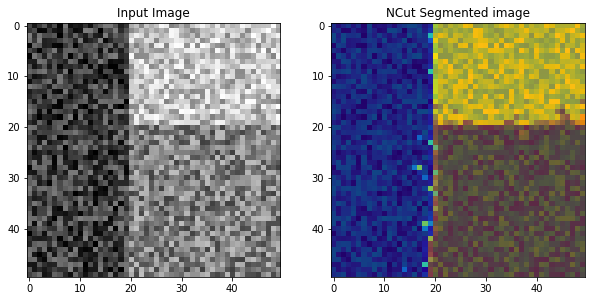


1st partition [ncut value= 0.006354960167920442]

Further partitioning Segment0 [ncut value= 0.04250892986683334]

Further partitioning Segment1 [ncut value= 0.016700821898991886]


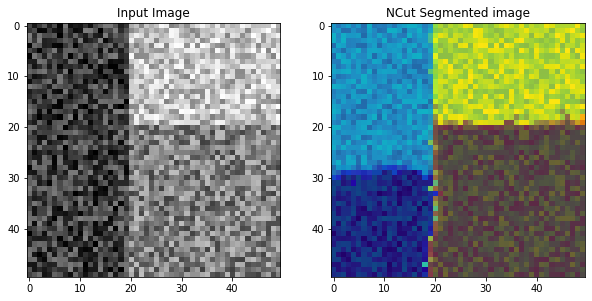



FCN Prediction


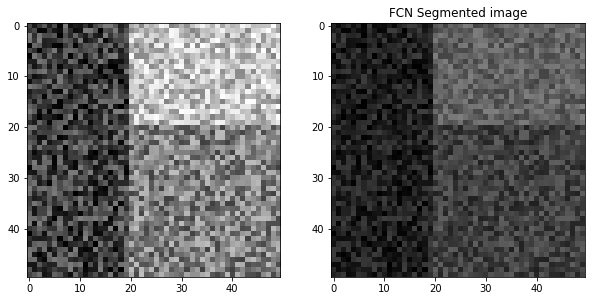

In [34]:
im1_path = Path('./images/image1.png')
segmented_image = ncut_image_segmentation(im1_path, sigma_x = 5, sigma_i = 0.01, r=8)
segmented_image = ncut_image_segmentation(im1_path, sigma_x = 5, sigma_i = 0.01, r=4)
fcn_out = fcn_predict(im1_path)


1st partition [ncut value= 0.004001474713116202]


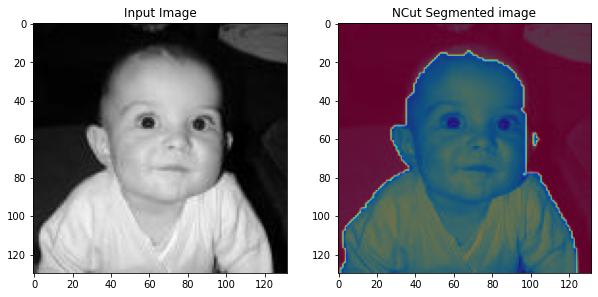


Further partitioning Segment0 [ncut value= 0.02300882278794238]


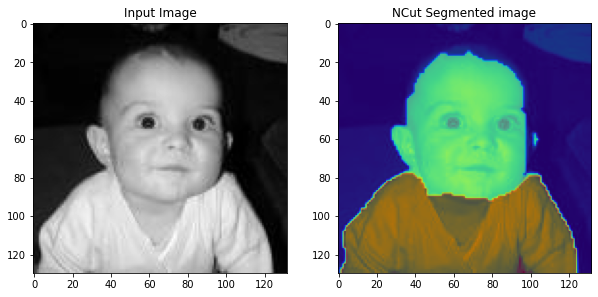


Further partitioning Segment1 [ncut value= 0.007184244291691677]


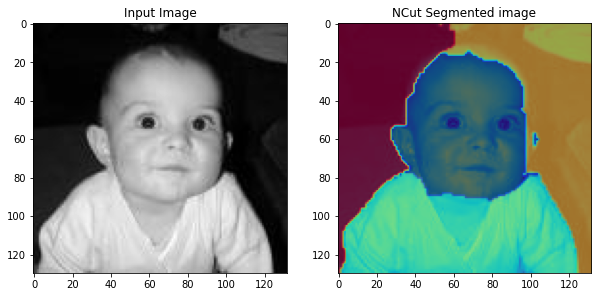

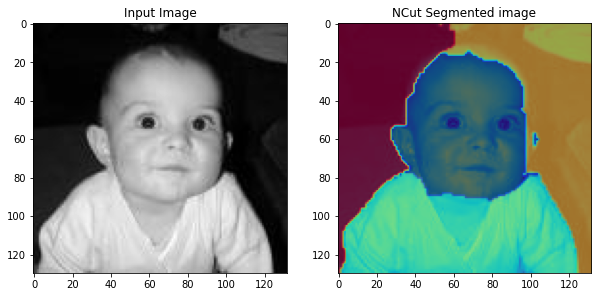



FCN Prediction


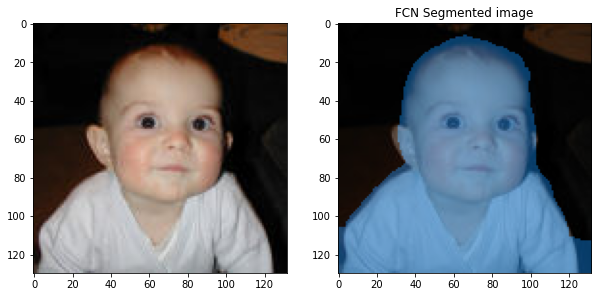

In [35]:
im2_path = Path('./images/baby.jpg')
segmented_image = ncut_image_segmentation(im2_path, plot_intermediate=True)
fcn_out = fcn_predict(im2_path)


1st partition [ncut value= 0.0019050617863804592]

Further partitioning Segment0 [ncut value= 0.01194411177760579]


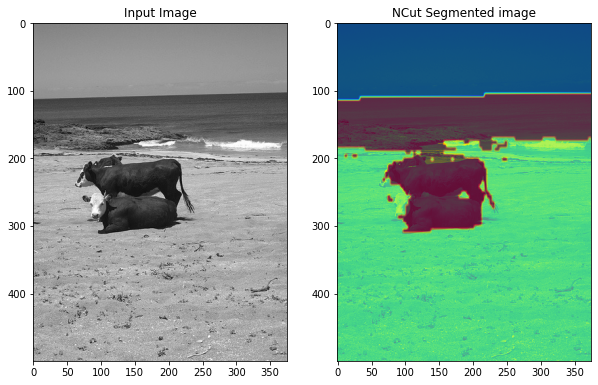



FCN Prediction


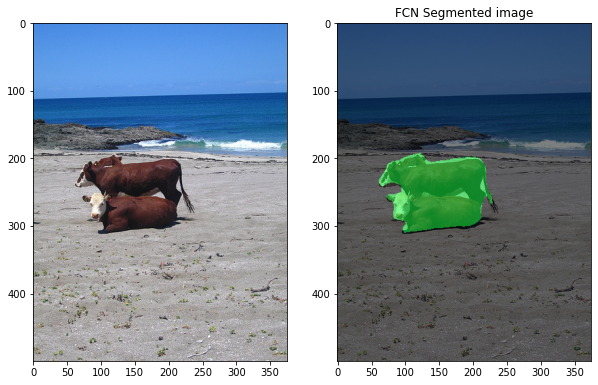

In [36]:
im3_path = Path('./images/2007_000464.jpg')
segmented_image = ncut_image_segmentation(im3_path, sigma_x = 5, sigma_i = 0.01, r=8)
fcn_out = fcn_predict(im3_path)


1st partition [ncut value= 0.007595676234586947]

Further partitioning Segment0 [ncut value= 0.028579636967675345]


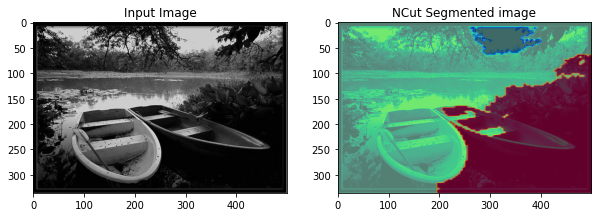



FCN Prediction


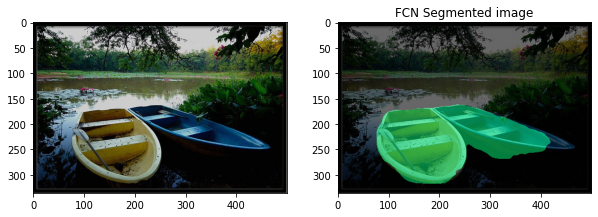

In [37]:
im4_path = Path('./images/2007_000713.jpg')
segmented_image = ncut_image_segmentation(im4_path, sigma_x = 5, sigma_i = 0.01, r=8)
fcn_out = fcn_predict(im4_path)


1st partition [ncut value= 0.076590597108616]


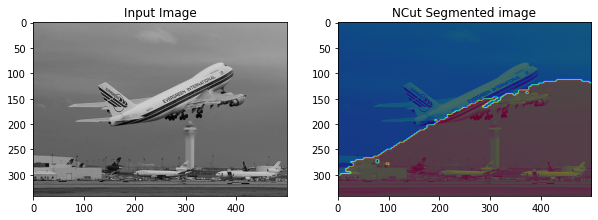



FCN Prediction


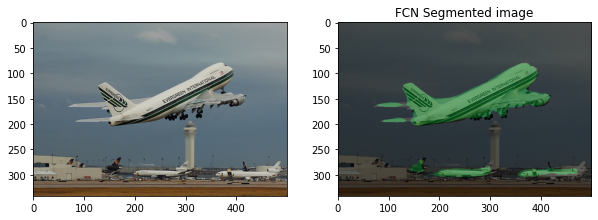

In [38]:
im5_path = Path('./images/2007_001288.jpg')
segmented_image = ncut_image_segmentation(im5_path, sigma_x = 5, sigma_i = 0.05, r=8)
fcn_out = fcn_predict(im5_path)


1st partition [ncut value= 0.01044587497722432]

Further partitioning Segment0 [ncut value= 0.016057498623709147]

Further partitioning Segment1 [ncut value= 0.01871024595038228]


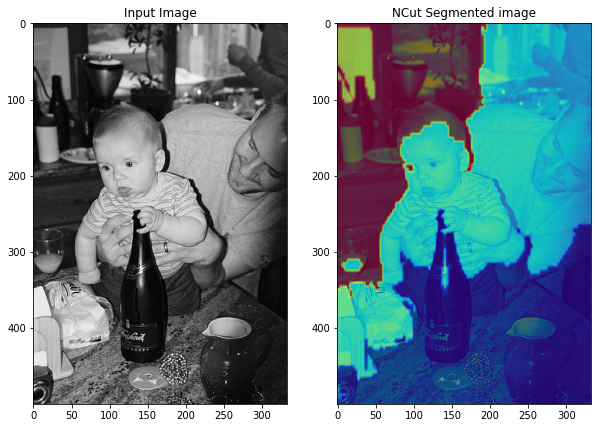



FCN Prediction


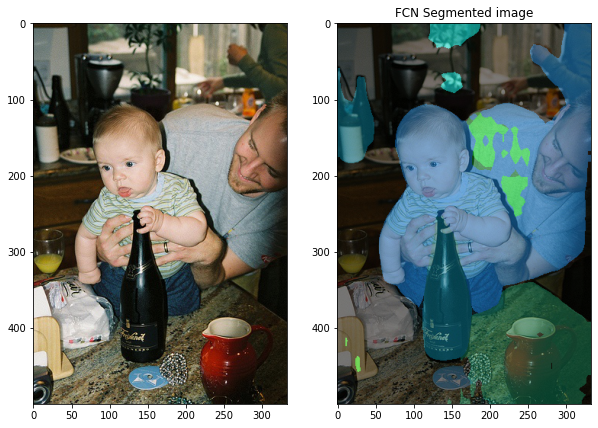

In [39]:
im_path = Path('./images/2007_001408.jpg')
segmented_image = ncut_image_segmentation(im_path, sigma_x = 5, sigma_i = 0.01, r=8)
fcn_out = fcn_predict(im_path)


1st partition [ncut value= 0.0009516057581765559]

Further partitioning Segment1 [ncut value= 0.04891525165956745]


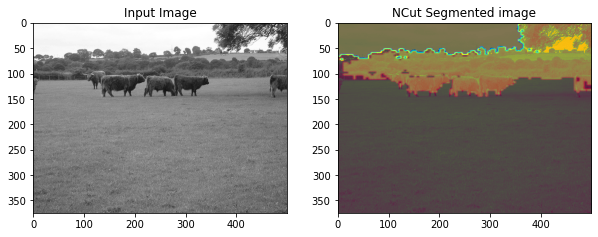



FCN Prediction


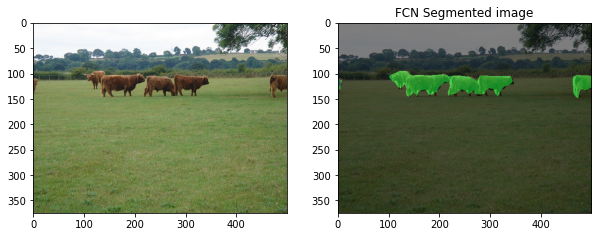

In [40]:
im_path = Path('./images/2007_001764.jpg')
segmented_image = ncut_image_segmentation(im_path, sigma_x = 5, sigma_i = 0.01, r=8, thresh = 0.08)
fcn_out = fcn_predict(im_path)


1st partition [ncut value= 0.010974084625471902]

Further partitioning Segment0 [ncut value= 0.044329066352084855]

Further partitioning Segment1 [ncut value= 0.053365888852833984]


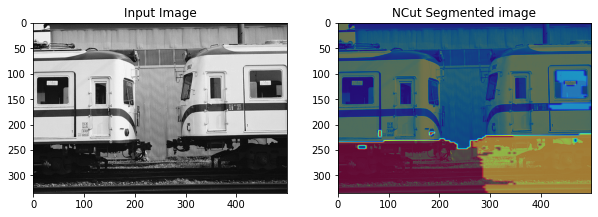



FCN Prediction


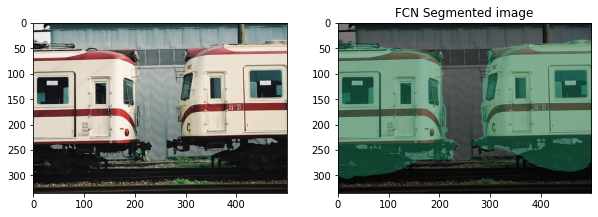

In [41]:
im_path = Path('./images/2007_000042.jpg')
segmented_image = ncut_image_segmentation(im_path, sigma_x = 5, sigma_i = 0.01, r=8, thresh = 0.08)
fcn_out = fcn_predict(im_path)